In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

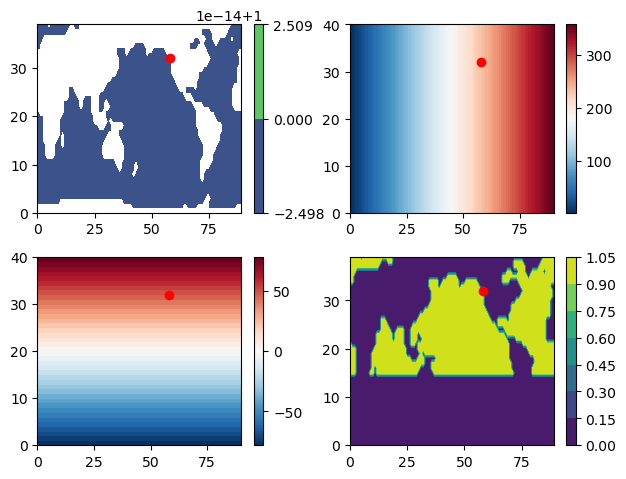

In [2]:
mainDir = '/scratch2/shreyas/global_oce_latlon_4x4'
spinupDir = mainDir + '/run_spinup'
gridDir = spinupDir + '/GRID'

nx = 90
ny = 40
nz = 15

latc = np.reshape(np.fromfile(gridDir + '/YC.data', 
                              dtype = '>f'), (ny, nx))
lonc = np.reshape(np.fromfile(gridDir + '/XC.data', 
                              dtype = '>f'), (ny, nx))
hfacc = np.reshape(np.fromfile(gridDir + '/hFacC.data', 
                              dtype = '>f'), (nz, ny, nx))

pmask = hfacc>0
pmask = pmask.astype(np.float32)
pmask[pmask == 0.0] = np.nan

fig, ax = plt.subplots(2,2)
fig.tight_layout()

pc = ax[0,0].contourf(pmask[0], cmap = 'viridis')
ax[0,0].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[0,0])

pc = ax[1,0].pcolor(latc, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[1,0])

pc = ax[0,1].pcolor(lonc, cmap = 'RdBu_r')
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[0,1])

latmask = latc >= -20
mask = pmask[0]
mask[np.isnan(mask)] = 0.0
latmask = mask * latmask
pc = ax[1,1].contourf(latmask, cmap = 'viridis')
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(pc, ax=ax[1,1])

In [3]:
### Number of wetpoints
int(np.sum(latmask))

1217

In [4]:
exptname = ['run_forward_50yr_dailydump_pk000059400', 
            'run_forward_50yr_dailydump_pk000061200']
diagsets = 'state3d_TS'
costLon  = 240
costLat  = 50

nx = 90
ny = 40
nz = 15

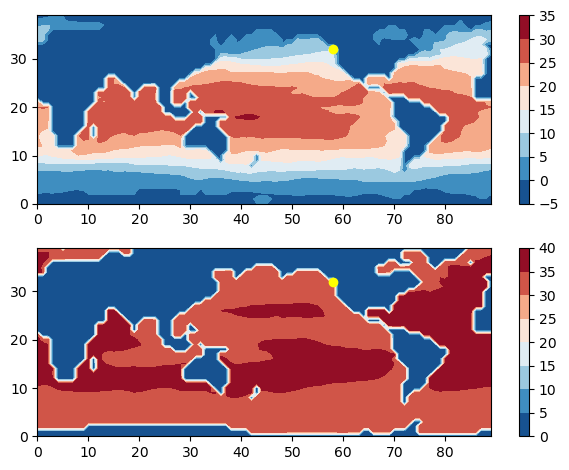

In [5]:
DataDirs = [mainDir + '/run_forward_50yr_dailydump_pk000059400/diags/untarred_output',
             mainDir + '/run_forward_50yr_dailydump_pk000061200/diags/untarred_output']

fileTS0 = DataDirs[0] + '/' + 'state3d_TS.0000594001.data'

T0 = np.reshape(np.fromfile(fileTS0, dtype = '>f')[:nx*ny*nz], (nz, ny, nx))
S0 = np.reshape(np.fromfile(fileTS0, dtype = '>f')[nx*ny*nz:], (nz, ny, nx))

fig, ax = plt.subplots(2,1)
fig.tight_layout()

pc = ax[0].contourf(T0[0]*pmask[0], cmap = 'RdBu_r')
ax[0].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[0])

pc = ax[1].contourf(S0[0]*pmask[0], cmap = 'RdBu_r')
ax[1].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[1])

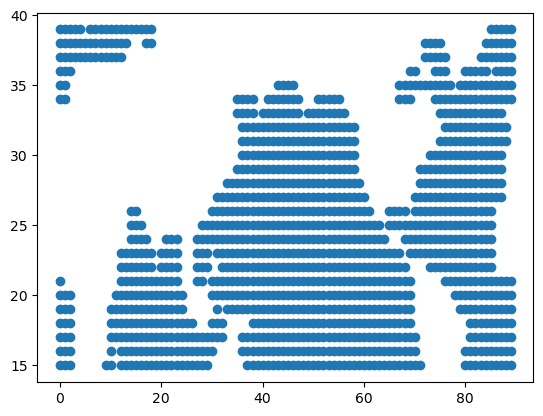

In [6]:
files_list = []
for i in range(18000):
    index = 594001 + i
    files_list.append(DataDirs[0] + '/' + f'state3d_TS.0000{index:6d}.data')
for i in range(18000):
    index = 612001 + i
    files_list.append(DataDirs[1] + '/' + f'state3d_TS.0000{index:6d}.data')
    
thetaSurf = np.zeros((len(files_list), ny, nx))
saltSurf = np.zeros((len(files_list), ny, nx))
cost = np.zeros((len(files_list), 1))
for i in range(len(files_list)):
    thetaSurf[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[:nx*ny*nz],
                          (nz, ny, nx))[0]
    cost[i] = thetaSurf[i,32,58]
    saltSurf[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[nx*ny*nz:],
                          (nz, ny, nx))[0]
    
wetpoints = np.nonzero(latmask)
thetaSurfWet = thetaSurf[:, wetpoints[0], wetpoints[1]]
saltSurfWet = saltSurf[:, wetpoints[0], wetpoints[1]]
plt.scatter(wetpoints[1], wetpoints[0])

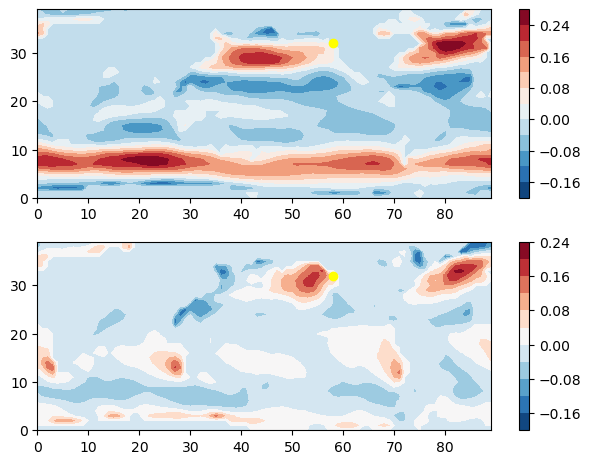

In [7]:
fileAtm0 = DataDirs[0] + '/' + 'state2d_atm.0000594001.data'

tauX0 = np.reshape(np.fromfile(fileAtm0, dtype = '>f')[7*nx*ny:8*nx*ny], (ny, nx))
tauY0 = np.reshape(np.fromfile(fileAtm0, dtype = '>f')[8*nx*ny:9*nx*ny], (ny, nx))

fig, ax = plt.subplots(2,1)
fig.tight_layout()

pc = ax[0].contourf(tauX0*pmask[0], cmap = 'RdBu_r', levels = 10)
ax[0].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[0])

pc = ax[1].contourf(tauY0*pmask[0], cmap = 'RdBu_r', levels = 10)
ax[1].scatter([58],[32], color = 'yellow')
fig.colorbar(pc, ax=ax[1])

In [8]:
files_list = []
for i in range(18000):
    index = 594001 + i
    files_list.append(DataDirs[0] + '/' + f'state2d_atm.0000{index:6d}.data')
for i in range(18000):
    index = 612001 + i
    files_list.append(DataDirs[1] + '/' + f'state2d_atm.0000{index:6d}.data')
    
tauX = np.zeros((len(files_list), ny, nx))
tauY = np.zeros((len(files_list), ny, nx))

for i in range(len(files_list)):
    tauX[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[7*nx*ny:8*nx*ny],
                          (ny, nx))
    tauY[i] = np.reshape(np.fromfile(files_list[i], dtype = '>f')[8*nx*ny:9*nx*ny],
                          (ny, nx))

wetpoints = np.nonzero(latmask)
tauXWet = tauX[:, wetpoints[0], wetpoints[1]]
tauYWet = tauY[:, wetpoints[0], wetpoints[1]]
tauWet = np.concatenate((tauXWet,tauYWet), axis = 1)

In [19]:
Layers = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(thetaSurfWet, cost, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    100, 50, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
cost_predict = best_model.predict(thetaSurfWet)

L = TrainLR(thetaSurfWet, cost, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

cost_predict_LR = regr.predict(thetaSurfWet)

Train on 28800 samples, validate on 7200 samples
Epoch 1/50
28700/28800 [============================>.] - ETA: 0s - loss: 40.2303 - mae: 2.1265
Epoch 1: val_loss improved from inf to 0.04505, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 2s 54us/sample - loss: 40.0907 - mae: 2.1197 - val_loss: 0.0451 - val_mae: 0.1826
Epoch 2/50
28800/28800 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.1010
Epoch 2: val_loss improved from 0.04505 to 0.00541, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 2s 53us/sample - loss: 0.0160 - mae: 0.1010 - val_loss: 0.0054 - val_mae: 0.0602
Epoch 3/50
28700/28800 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0495
Epoch 3: val_loss improved from 0.00541 to 0.00354, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 1s 49us/sample - loss: 0.0038 - mae: 0.0495 - v

Epoch 29/50
28200/28800 [============================>.] - ETA: 0s - loss: 0.0628 - mae: 0.1287
Epoch 29: val_loss did not improve from 0.00046
28800/28800 [==============================] - 1s 50us/sample - loss: 0.0616 - mae: 0.1267 - val_loss: 0.0027 - val_mae: 0.0491
Epoch 30/50
28100/28800 [============================>.] - ETA: 0s - loss: 0.1258 - mae: 0.1838
Epoch 30: val_loss did not improve from 0.00046
28800/28800 [==============================] - 1s 46us/sample - loss: 0.1267 - mae: 0.1874 - val_loss: 0.1541 - val_mae: 0.3918
Epoch 31/50
28500/28800 [============================>.] - ETA: 0s - loss: 0.1338 - mae: 0.2187
Epoch 31: val_loss did not improve from 0.00046
28800/28800 [==============================] - 1s 42us/sample - loss: 0.1327 - mae: 0.2178 - val_loss: 0.0020 - val_mae: 0.0393
Epoch 32/50
27800/28800 [===========================>..] - ETA: 0s - loss: 0.0771 - mae: 0.1543
Epoch 32: val_loss did not improve from 0.00046
28800/28800 [===========================

In [20]:
base_pt = 0
num_rel = 360
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_a1b0 = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_a1b0[:,:,:] = np.nan
rel_a1b0[:,wetpoints[0],wetpoints[1]] = a

X = XAIR(best_model, 'lrp.z', 'classic', thetaSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_z = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_z[:,:,:] = np.nan
rel_z[:,wetpoints[0],wetpoints[1]] = a

XL = XLR(regr, thetaSurfWet[base_pt:base_pt+num_rel])
a_LR, stats_LR = XL.quick_analyze()

rel_LR = np.zeros((num_rel, thetaSurf.shape[1], thetaSurf.shape[2]))
rel_LR[:,:,:] = np.nan
rel_LR[:,wetpoints[0],wetpoints[1]] = a_LR

Text(0.5, 1.0, 'Mean annual LRP_LR')

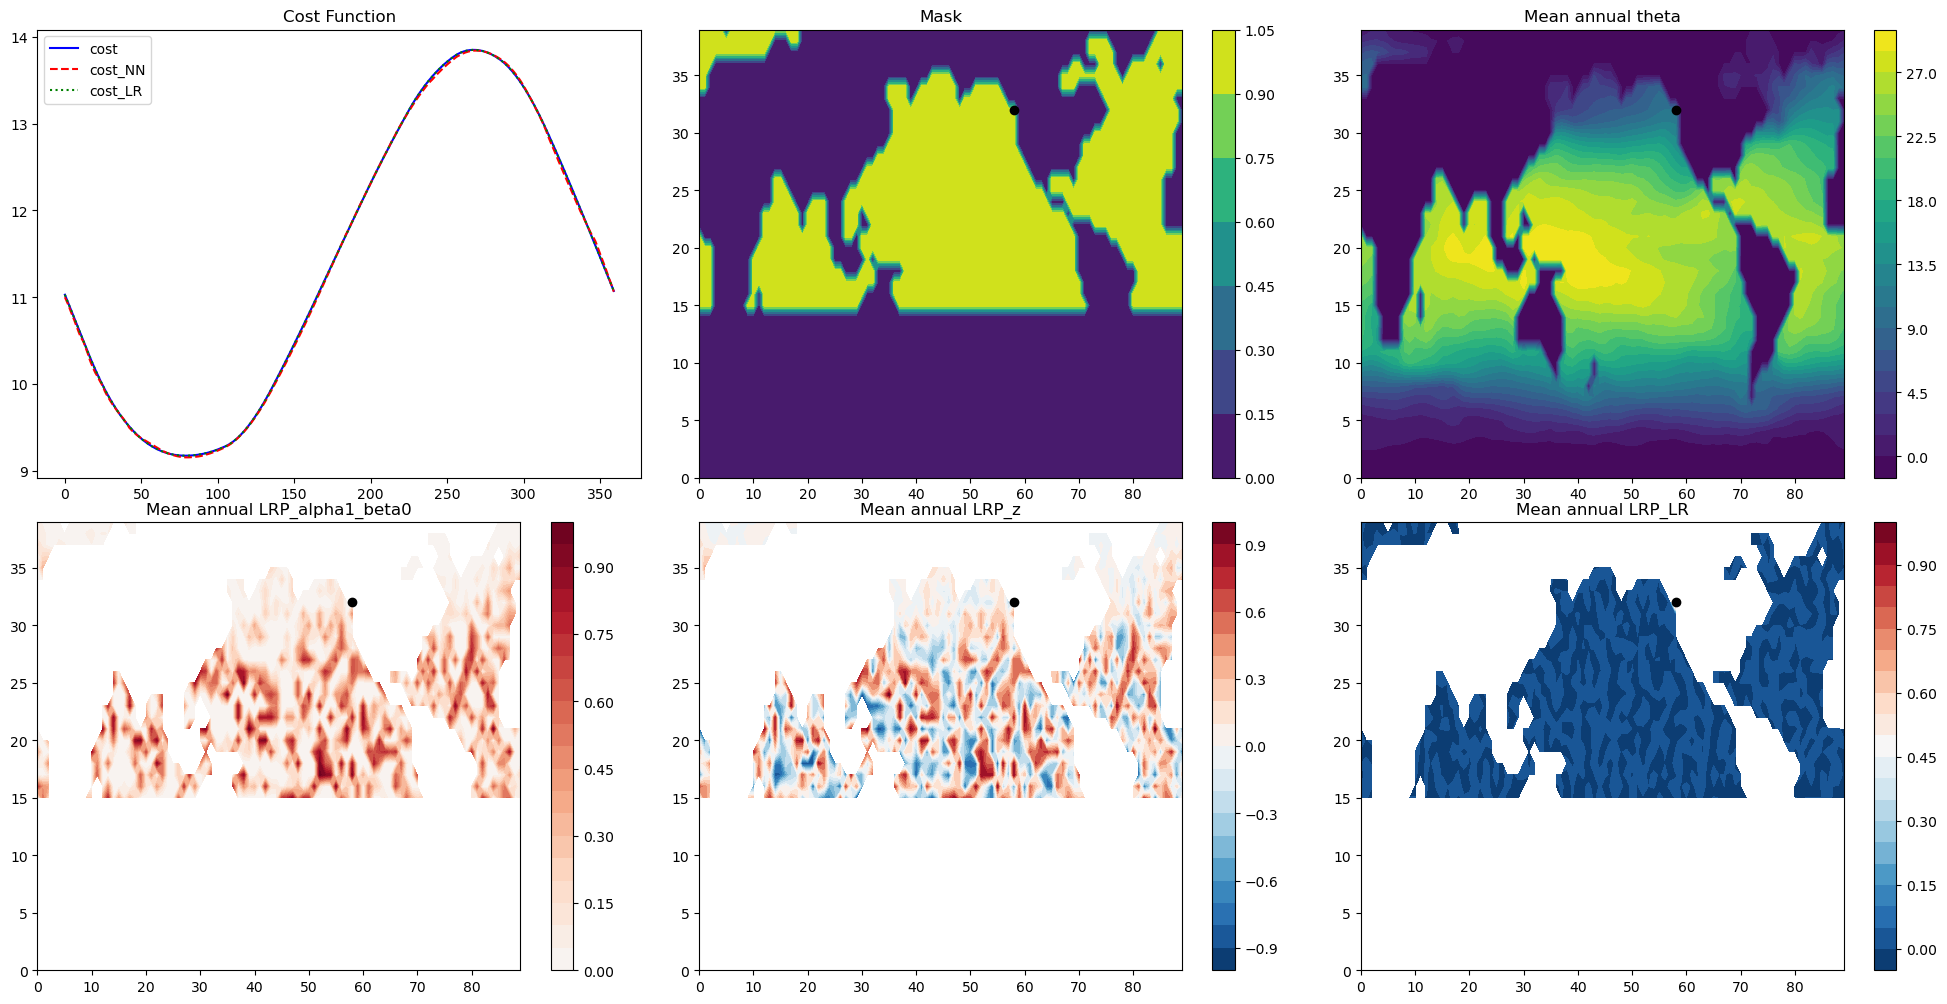

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:360], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:360], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:360], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(np.mean(thetaSurf, axis = 0), levels = 20)
ax[0,2].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Mean annual theta')

p = ax[1,0].contourf(np.mean(rel_a1b0, axis = 0), vmin=-1, vmax=1, levels = 20, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('Mean annual LRP_alpha1_beta0')

p = ax[1,1].contourf(np.mean(rel_z, axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,1].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('Mean annual LRP_z')

p = ax[1,2].contourf(np.mean(rel_LR, axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,2].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('Mean annual LRP_LR')

In [16]:
Layers = [{'size': saltSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(saltSurfWet, cost, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 50, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
cost_predict = best_model.predict(saltSurfWet)

L = TrainLR(saltSurfWet, cost, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

cost_predict_LR = regr.predict(saltSurfWet)

Train on 28800 samples, validate on 7200 samples
Epoch 1/50
28450/28800 [============================>.] - ETA: 0s - loss: 13.3438 - mae: 2.2700
Epoch 1: val_loss improved from inf to 6.69422, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 4s 151us/sample - loss: 13.2312 - mae: 2.2620 - val_loss: 6.6942 - val_mae: 2.2687
Epoch 2/50
28720/28800 [============================>.] - ETA: 0s - loss: 5.9055 - mae: 1.9327
Epoch 2: val_loss improved from 6.69422 to 2.71453, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 5s 171us/sample - loss: 5.8920 - mae: 1.9298 - val_loss: 2.7145 - val_mae: 1.3209
Epoch 3/50
28440/28800 [============================>.] - ETA: 0s - loss: 3.9542 - mae: 1.5993
Epoch 3: val_loss did not improve from 2.71453
28800/28800 [==============================] - 4s 130us/sample - loss: 3.9386 - mae: 1.5962 - val_loss: 3.3890 - val_mae: 1.6125
Epoch 4/50
28590/28800

28690/28800 [============================>.] - ETA: 0s - loss: 0.1018 - mae: 0.2535
Epoch 28: val_loss improved from 0.02812 to 0.01704, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 4s 154us/sample - loss: 0.1027 - mae: 0.2545 - val_loss: 0.0170 - val_mae: 0.1016
Epoch 29/50
28770/28800 [============================>.] - ETA: 0s - loss: 0.1007 - mae: 0.2535
Epoch 29: val_loss did not improve from 0.01704
28800/28800 [==============================] - 5s 162us/sample - loss: 0.1008 - mae: 0.2535 - val_loss: 0.0351 - val_mae: 0.1516
Epoch 30/50
28800/28800 [==============================] - ETA: 0s - loss: 0.1022 - mae: 0.2541
Epoch 30: val_loss did not improve from 0.01704
28800/28800 [==============================] - 5s 162us/sample - loss: 0.1022 - mae: 0.2541 - val_loss: 0.0730 - val_mae: 0.2393
Epoch 31/50
28470/28800 [============================>.] - ETA: 0s - loss: 0.0912 - mae: 0.2400
Epoch 31: val_loss did not improve fro

In [17]:
base_pt = 0
num_rel = 360
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', saltSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_a1b0 = np.zeros((num_rel, saltSurf.shape[1], saltSurf.shape[2]))
rel_a1b0[:,:,:] = np.nan
rel_a1b0[:,wetpoints[0],wetpoints[1]] = a

X = XAIR(best_model, 'lrp.z', 'classic', saltSurfWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_z = np.zeros((num_rel, saltSurf.shape[1], saltSurf.shape[2]))
rel_z[:,:,:] = np.nan
rel_z[:,wetpoints[0],wetpoints[1]] = a

XL = XLR(regr, saltSurfWet[base_pt:base_pt+num_rel])
a_LR, stats_LR = XL.quick_analyze()

rel_LR = np.zeros((num_rel, saltSurf.shape[1], saltSurf.shape[2]))
rel_LR[:,:,:] = np.nan
rel_LR[:,wetpoints[0],wetpoints[1]] = a_LR

Text(0.5, 1.0, 'Mean annual LRP_LR')

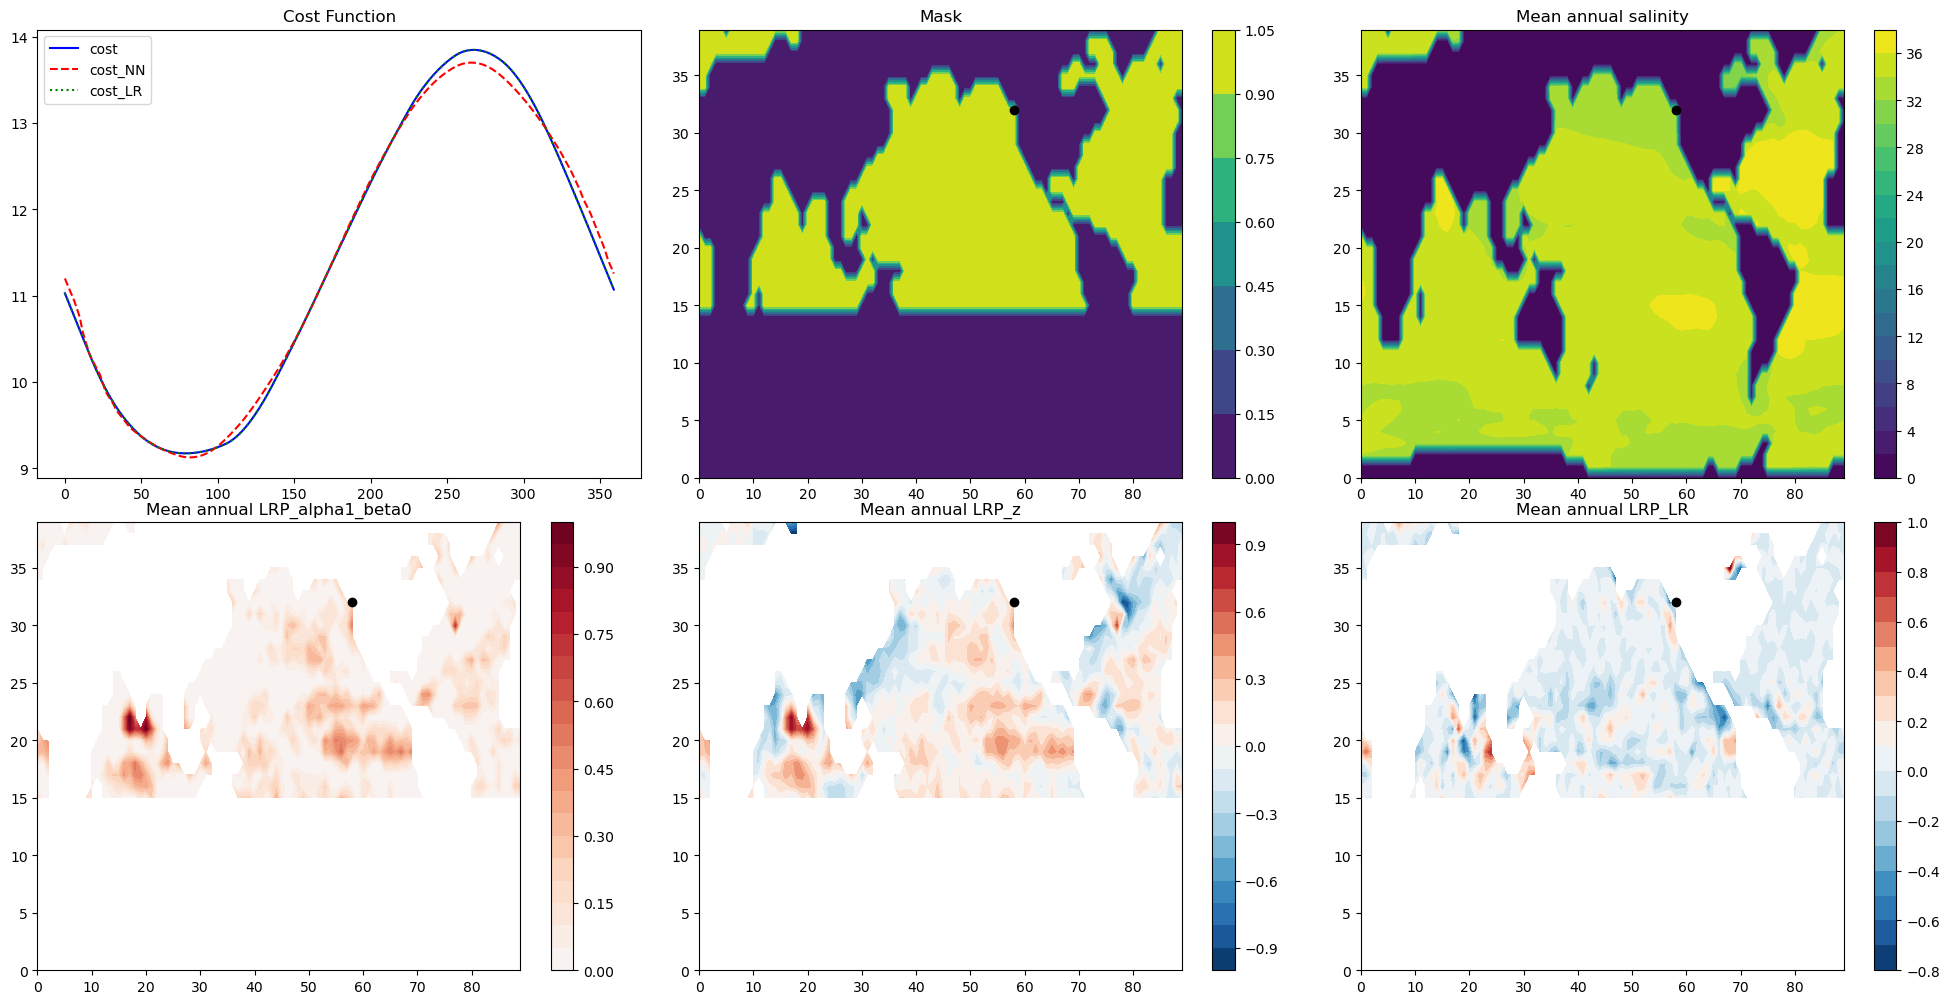

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:360], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:360], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:360], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(np.mean(saltSurf, axis = 0), levels = 20)
ax[0,2].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Mean annual salinity')

p = ax[1,0].contourf(np.mean(rel_a1b0, axis = 0), vmin=-1, vmax=1, levels = 20, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('Mean annual LRP_alpha1_beta0')

p = ax[1,1].contourf(np.mean(rel_z, axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,1].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('Mean annual LRP_z')

p = ax[1,2].contourf(np.mean(rel_LR, axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,2].scatter([58],[32], color = 'black')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('Mean annual LRP_LR')

In [11]:
Layers = [{'size': tauWet.shape[1]   , 'activation': None    , 'use_bias': None},
          {'size': 40                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(tauWet, cost, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 20, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()
cost_predict = best_model.predict(tauWet)

L = TrainLR(tauWet, cost, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

cost_predict_LR = regr.predict(tauWet)

Train on 28800 samples, validate on 7200 samples
Epoch 1/20
28670/28800 [============================>.] - ETA: 0s - loss: 1.0666 - mae: 0.2460
Epoch 1: val_loss improved from inf to 0.00054, saving model to /home/shreyas/XAIRT/examples/model.h5
28800/28800 [==============================] - 7s 230us/sample - loss: 1.0618 - mae: 0.2449 - val_loss: 5.4066e-04 - val_mae: 0.0175
Epoch 2/20
28660/28800 [============================>.] - ETA: 0s - loss: 6.9781e-04 - mae: 0.0206
Epoch 2: val_loss did not improve from 0.00054
28800/28800 [==============================] - 7s 241us/sample - loss: 7.0050e-04 - mae: 0.0207 - val_loss: 8.8474e-04 - val_mae: 0.0242
Epoch 3/20
28690/28800 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0298
Epoch 3: val_loss did not improve from 0.00054
28800/28800 [==============================] - 6s 202us/sample - loss: 0.0015 - mae: 0.0298 - val_loss: 0.0017 - val_mae: 0.0336
Epoch 4/20
28790/28800 [============================>.] - ETA: 0s -

In [12]:
base_pt = 0
num_rel = 360
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', tauWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_a1b0 = np.zeros((2, num_rel, tauX.shape[1], tauX.shape[2]))
rel_a1b0[:,:,:,:] = np.nan
rel_a1b0[0,:,wetpoints[0],wetpoints[1]] = a[:,:len(wetpoints[0])].T
rel_a1b0[1,:,wetpoints[0],wetpoints[1]] = a[:,len(wetpoints[0]):].T

X = XAIR(best_model, 'lrp.z', 'classic', tauWet[base_pt:base_pt+num_rel], normalizeDict, **kwargs)
a, stats  = X.quick_analyze()

rel_z = np.zeros((2, num_rel, tauX.shape[1], tauX.shape[2]))
rel_z[:,:,:,:] = np.nan
rel_z[0,:,wetpoints[0],wetpoints[1]] = a[:,:len(wetpoints[0])].T
rel_z[1,:,wetpoints[0],wetpoints[1]] = a[:,len(wetpoints[0]):].T

XL = XLR(regr, tauWet[base_pt:base_pt+num_rel])
a_LR, stats_LR = XL.quick_analyze()

rel_LR = np.zeros((2, num_rel, tauX.shape[1], tauX.shape[2]))
rel_LR[:,:,:,:] = np.nan
rel_LR[0,:,wetpoints[0],wetpoints[1]] = a_LR[:,:len(wetpoints[0])].T
rel_LR[1,:,wetpoints[0],wetpoints[1]] = a_LR[:,len(wetpoints[0]):].T

Text(0.5, 1.0, 'Mean annual LRP_LR')

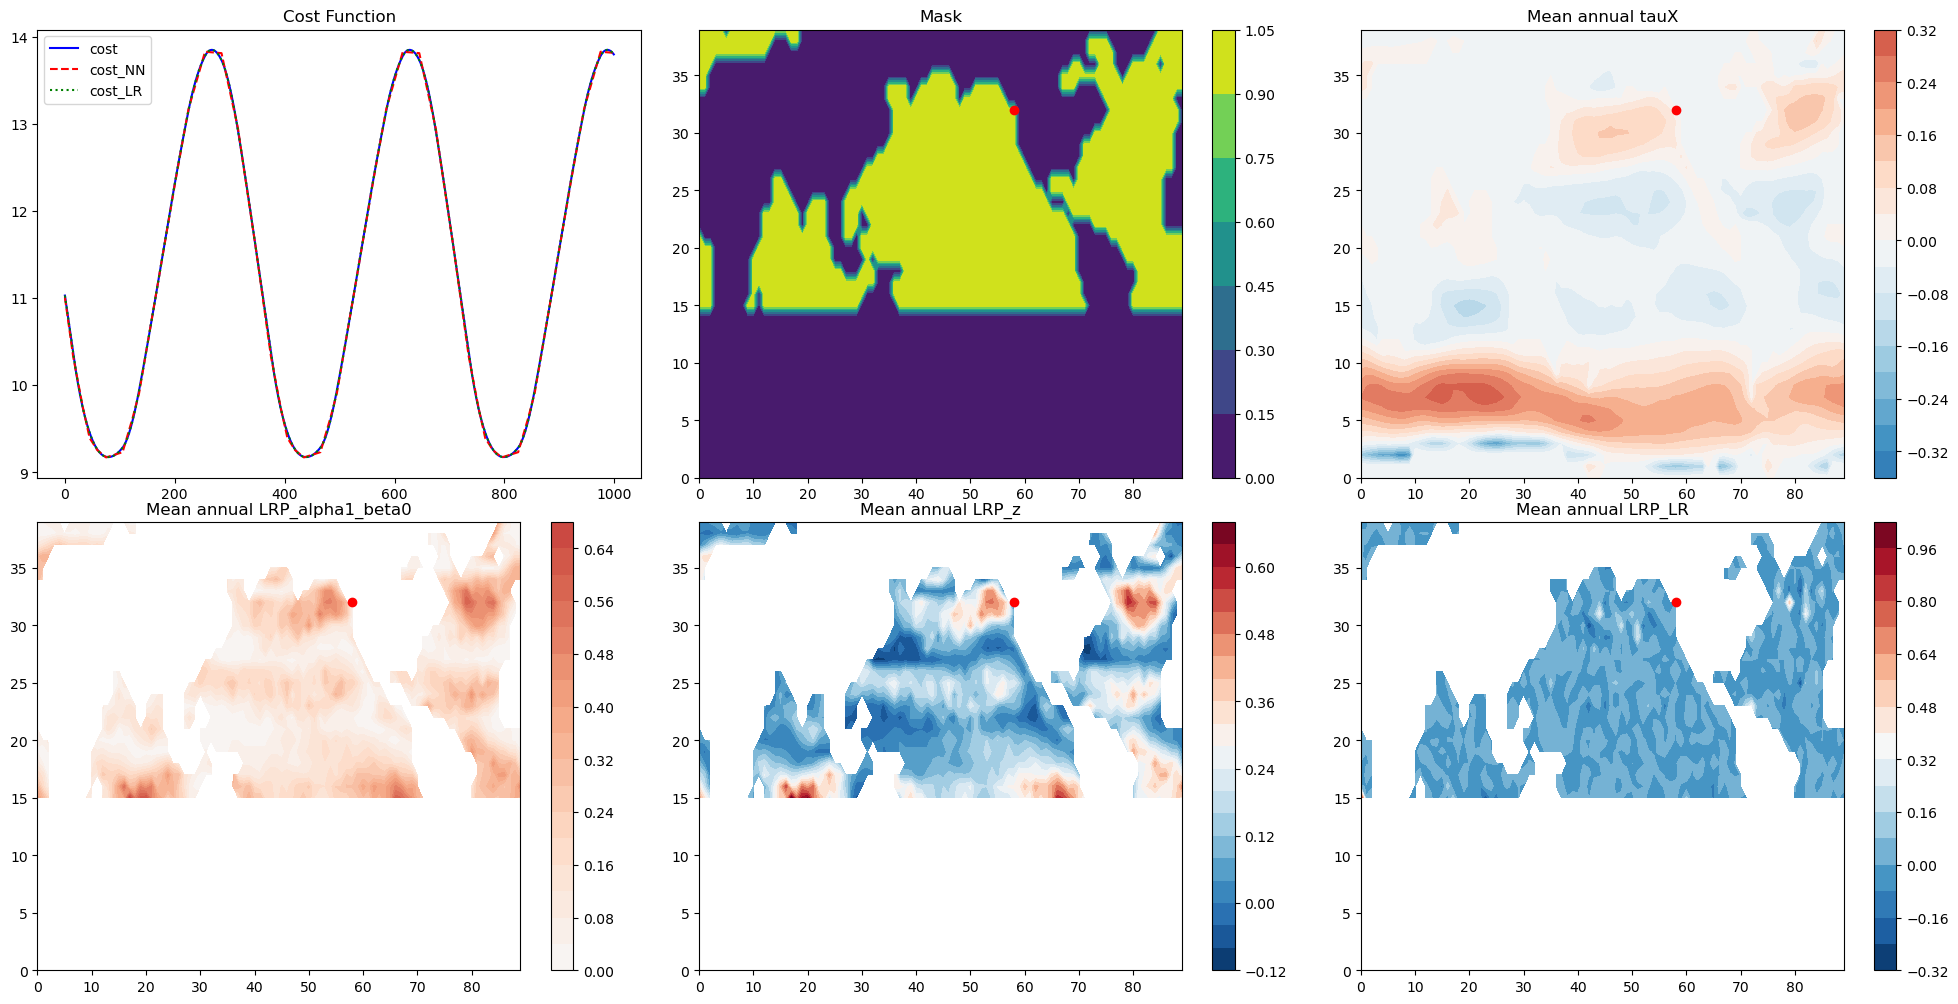

In [13]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:1000], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:1000], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:1000], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(np.mean(tauX, axis = 0)*pmask[0], vmin=-0.5, vmax=0.5, levels = 20, cmap = 'RdBu_r')
ax[0,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Mean annual tauX')

p = ax[1,0].contourf(np.mean(rel_a1b0[0], axis = 0), vmin=-1, vmax=1, levels = 20, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('Mean annual LRP_alpha1_beta0')

p = ax[1,1].contourf(np.mean(rel_z[0], axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('Mean annual LRP_z')

p = ax[1,2].contourf(np.mean(rel_LR[0], axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('Mean annual LRP_LR')

Text(0.5, 1.0, 'Mean annual LRP_LR')

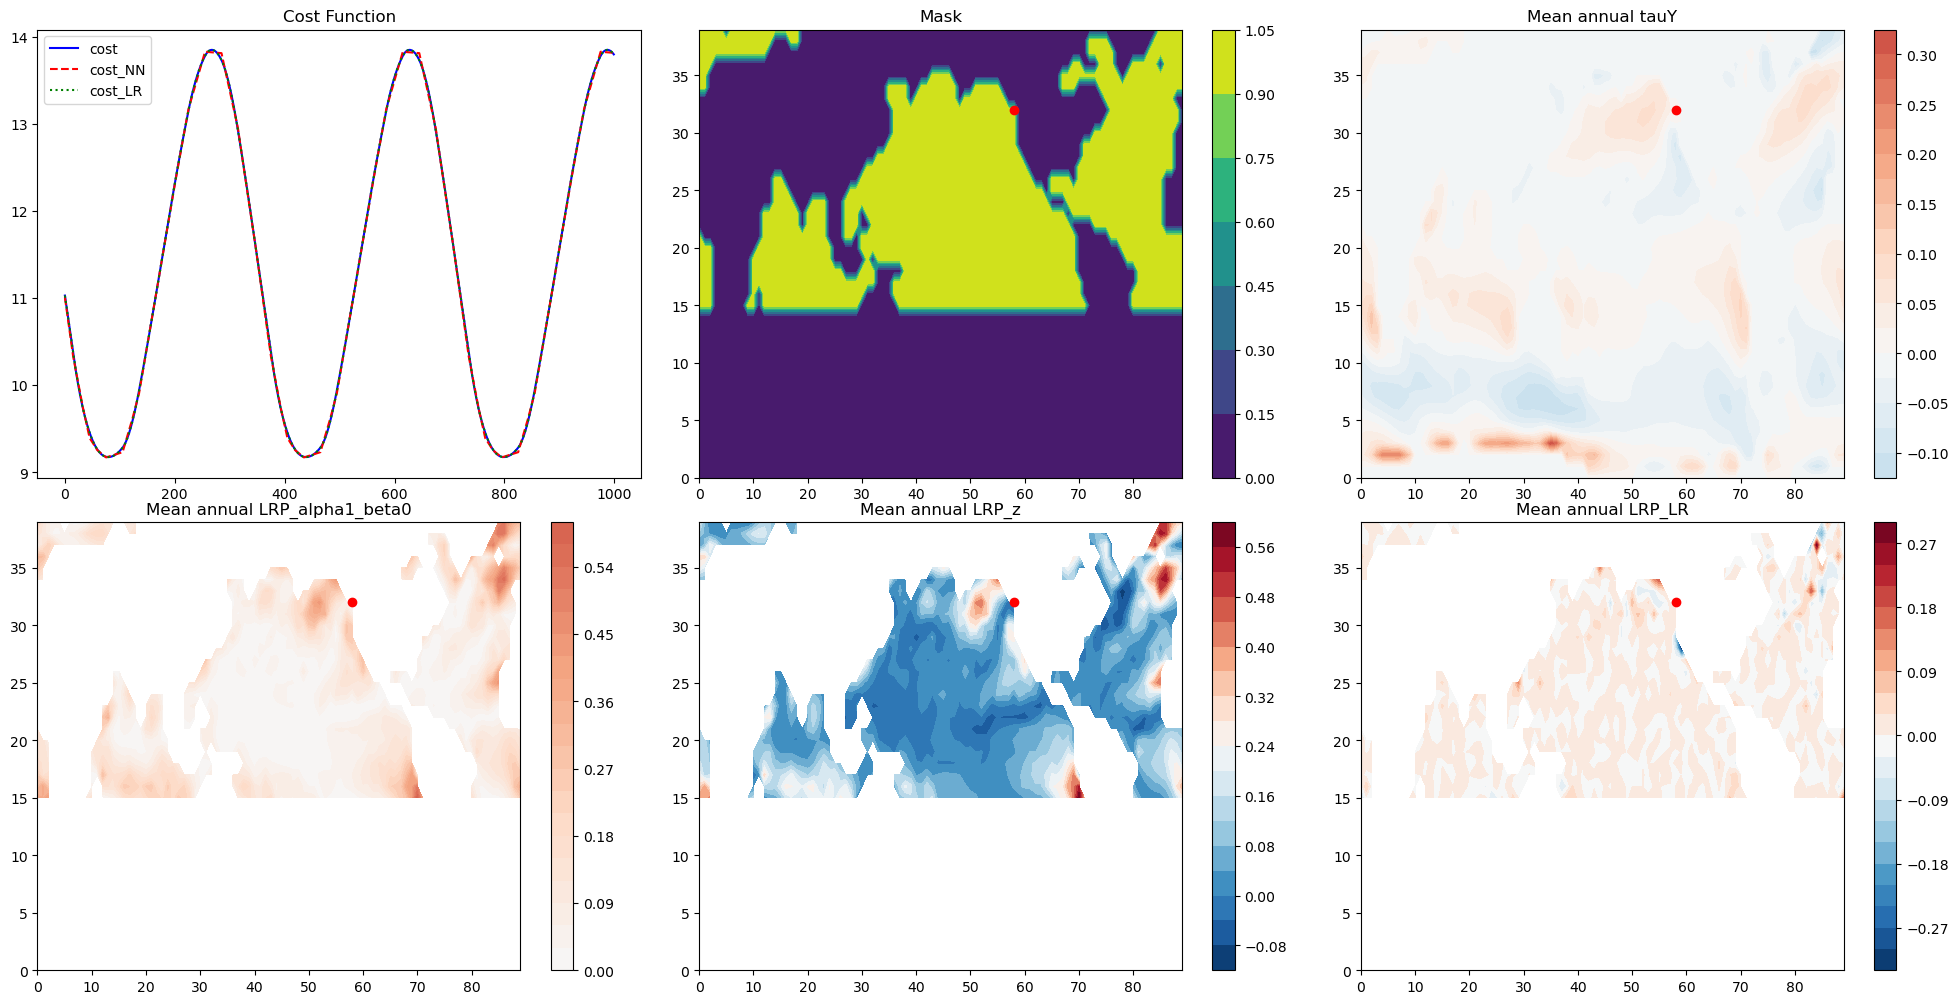

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
fig.tight_layout()

ax[0,0].plot(cost[:1000], 'b', label = 'cost')
ax[0,0].plot(cost_predict[:1000], 'r--', label = 'cost_NN')
ax[0,0].plot(cost_predict_LR[:1000], 'g:', label = 'cost_LR')
ax[0,0].legend()
ax[0,0].set_title('Cost Function')

p = ax[0,1].contourf(latmask)
ax[0,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,1])
ax[0,1].set_title('Mask')

p = ax[0,2].contourf(np.mean(tauY, axis = 0)*pmask[0], vmin=-0.5, vmax=0.5, levels = 20, cmap = 'RdBu_r')
ax[0,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[0,2])
ax[0,2].set_title('Mean annual tauY')

p = ax[1,0].contourf(np.mean(rel_a1b0[1], axis = 0), vmin=-1, vmax=1, levels = 20, cmap = 'RdBu_r')
ax[1,0].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,0])
ax[1,0].set_title('Mean annual LRP_alpha1_beta0')

p = ax[1,1].contourf(np.mean(rel_z[1], axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,1].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,1])
ax[1,1].set_title('Mean annual LRP_z')

p = ax[1,2].contourf(np.mean(rel_LR[1], axis = 0), levels = 20, cmap = 'RdBu_r')
ax[1,2].scatter([58],[32], color = 'red')
fig.colorbar(p, ax=ax[1,2])
ax[1,2].set_title('Mean annual LRP_LR')